In [1]:
# important imports for this notebook
from absl import logging
import flax
import jax.numpy as jnp
import jax
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

import optax
from flax.training import train_state
from flax.metrics import tensorboard

tf.config.experimental.set_visible_devices([], "GPU")

logging.set_verbosity(logging.INFO)

2024-06-05 22:16:46.893341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 22:16:46.893421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 22:16:46.895258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 22:16:47.900905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
logical_devices

2.15.0


[]

In [3]:
# make sure we are on GPU
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


In [4]:
# Load in a dataset - start with mnist

# These commands break up the load command into it's parts for more controls
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
# 60000 training samples - no shuffle, no batch causes this to return a tensor of
# all of the data instead of a tensorflow dataset structure - we won't use tf.data
# here and just want to convert to numpy - these return dictionaries
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

# convert to 0 - 1 range for neural network training - don't want an arbitrary weight
# which could cause large gradients and difficult training.
train_ds['image'] = np.float16(train_ds['image']) / 255.0
test_ds['image'] = np.float16(test_ds['image']) / 255.0

INFO:absl:Load dataset info from /home/don/tensorflow_datasets/mnist/3.0.1
INFO:absl:For 'mnist/3.0.1': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/don/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/don/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/don/tensorflow_datasets/mnist/3.0.1


In [7]:
jax.local_device_count()

1

In [62]:
ds=ds_builder.as_dataset(split='train')
ds = ds.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE).take(4)

INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/don/tensorflow_datasets/mnist/3.0.1


In [68]:
import einops

shard = lambda x: einops.rearrange(
    x, '(d b) ... -> d b ...', d=jax.local_device_count())
unshard = lambda x: einops.rearrange(x, 'd b ... -> (d b) ...')

correct = total = 0
for batch in ds.as_numpy_iterator():
    images = batch['image']
    n = len(images)
    # The star operator here unrolls the resulting tuple to be used as arguments
    # to construct the new array. So this function just creates zero arrays in 
    # the shape of the remainder in a batch set
    padding = np.zeros([128 - 64, *images.shape[1:]], images.dtype)
    # Then we would add these pads to the image batch
    padded_images = np.concatenate([images, padding])
    # Then we would shard the batch across devices, make our predictions, unshard
    # the result into the original batch dimensions, but then throw away the 
    # padded predictions before calculating any loss or metrics.
    preds = unshard(get_preds(variables, shard(padded_images)))[:n]


(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)


2024-06-05 22:49:20.681197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [78]:
[10, *images.shape[1:]]

[10, (28, 28, 1)]

In [3]:
train_ds['image'][0].shape

(28, 28, 1)

In [5]:
test_ds

{'id': array([b'test_09933', b'test_05669', b'test_00163', ..., b'test_03829',
        b'test_08858', b'test_04202'], dtype=object),
 'image': array([[[[0.7058824 , 0.7294118 , 0.7411765 ],
          [0.6313726 , 0.654902  , 0.65882355],
          [0.54901963, 0.57254905, 0.5568628 ],
          ...,
          [0.20392157, 0.21568628, 0.15686275],
          [0.2       , 0.21568628, 0.15686275],
          [0.2       , 0.21176471, 0.15686275]],
 
         [[0.6745098 , 0.69803923, 0.6901961 ],
          [0.5882353 , 0.6117647 , 0.6       ],
          [0.4627451 , 0.49019608, 0.4627451 ],
          ...,
          [0.1764706 , 0.18431373, 0.12941177],
          [0.16862746, 0.1764706 , 0.12156863],
          [0.17254902, 0.1882353 , 0.13333334]],
 
         [[0.6313726 , 0.65882355, 0.627451  ],
          [0.5764706 , 0.60784316, 0.57254905],
          [0.47058824, 0.49803922, 0.4627451 ],
          ...,
          [0.16470589, 0.1882353 , 0.12941177],
          [0.16862746, 0.19607843, 0.13

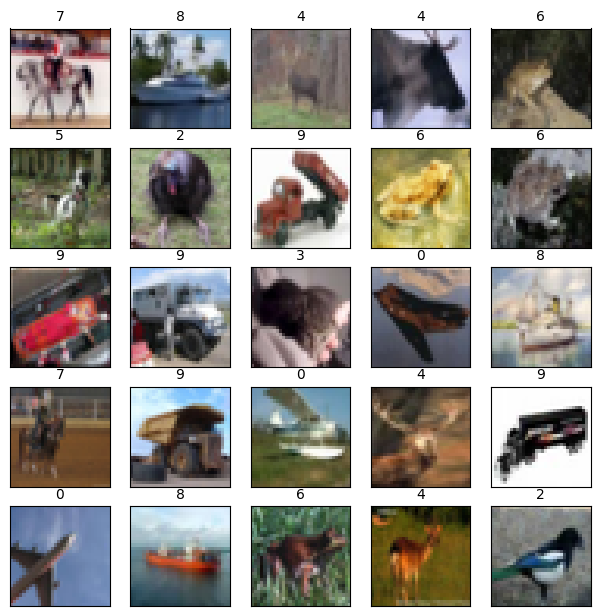

In [3]:
# Always good to check the data to make sure it loaded in properly
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title, fontsize=10)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(1.5 * n, 1.5 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

show_img_grid(
    [np.float32(train_ds['image'][idx]) for idx in range(25)],
    [f'{train_ds["label"][idx]}' for idx in range(25)],
)
     

In [4]:
%load_ext tensorboard
%tensorboard --logdir='flax_runs'

In [5]:
# set up a convolutional model for image data in flax
from flax import linen as nn
from functools import partial

class CNN(nn.Module):
     # dtype for fp16/32 training
    dtype = jnp.float16

    @nn.compact
    def __call__(self, x, training: bool):
        norm = partial(
            nn.BatchNorm,
            use_running_average=not training,
            momentum=0.1,
            epsilon=1e-5,
            dtype=self.dtype,
        )
         
        # this is like the sequential model from Haiku
        x = nn.Conv(features=16, kernel_size=(3, 3), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        #x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        residual = x
        x = nn.Conv(features=16, kernel_size=(3, 3), strides=(1, 1), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        #x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        #x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=16, kernel_size=(3, 3), strides=(1, 1), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x + residual)

        residual = x
        x = nn.Conv(features=16, kernel_size=(3, 3), strides=(1, 1), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        #x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        #x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=16, kernel_size=(3, 3), strides=(1, 1), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x + residual)

        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1)) #flatten the outputs
        x = nn.Dense(features=256, dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)

        # Need 10 output logits (1 per number) - thesse are assumed
        # to be log(probabilites) and will be fed into a softmax
        # layer at evaluation time. the softmax could also be placed
        # here
        x = nn.Dense(features=10, dtype=self.dtype)(x)
        
        return x

In [6]:
# test the model
batch_size = 64
learning_rate = 0.001

rng = jax.random.key(0)

model = CNN()

batch = jnp.ones([1, 32, 32, 3], dtype=jnp.float16)

rng, init_rng = jax.random.split(rng)

# initialize the model (i.e. generate random weights / parameters )
variables = model.init(init_rng, batch, training=False)
params = variables['params']
batch_stats = variables['batch_stats']

rng, dropout_key = jax.random.split(rng)

# params has to go in a kwarg
y, updates = model.apply({'params': params, 'batch_stats': batch_stats}, batch, training=True, rngs={'dropout': dropout_key}, mutable=['batch_stats'])

In [45]:
y

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float16)

In [79]:
print(model.tabulate(jax.random.key(0), jnp.ones((32, 32, 32, 3)), training=True,
                   compute_flops=True, compute_vjp_flops=True))

TypeError: Value Dense(
    # attributes
    features = 10
    use_bias = True
    dtype = Traced<ShapedArray(float32[32,256])>with<DynamicJaxprTrace(level=1/0)>
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = None
    dot_general_cls = None
) with type <class 'flax.linen.linear.Dense'> is not a valid JAX type

In [7]:
# We need a function to apply the gradients to the model, which will
# update the parameters - can be used to update the model, or we 
# can ignore the gradients and calculate stats for the test set
@jax.jit
def apply_model(state, images, labels, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats}, 
            images, training=True, 
            rngs={'dropout': dropout_train_key}, 
            mutable=['batch_stats'])
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, (logits, updates)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, updates, accuracy

@jax.jit
def apply_model_test(state, images, labels, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
    def loss_fn(params):
        logits, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats}, images, training=False, rngs={'dropout': dropout_train_key}, mutable=['batch_stats'])
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, (logits, updates)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, updates, accuracy

In [8]:
# simulate one training run
# initialize optax with a particular training algorithm
from typing import Any

tx = optax.adam(learning_rate=learning_rate)

class TrainState(train_state.TrainState):
  key: jax.Array
  batch_stats: Any

# we then store the state of the training (current parameters, state of optax, and the function to apply)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, key=dropout_key, batch_stats=batch_stats)

train_ds_size = len(train_ds['image'])
# Once we have a random permutation of data, this is how many times we 
# will need ot divide it up to get the required batches
steps_per_epoch = train_ds_size // batch_size

# Get a random permutation
perms = np.random.permutation(len(train_ds['image']))
perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
perms = perms.reshape((steps_per_epoch, batch_size))

# So perms will just be a list of indcies into the original training dataset

# This is what one batch of the permutation looks like then
batch_images = train_ds['image'][perms[0], ...]
batch_labels = train_ds['label'][perms[0], ...]

# 1 - apply model - apply the model to the current batch images, get the logits,
# get the loss, and calculate the gradients over the current batch
grads, loss, updates, accuracy = apply_model(state, batch_images, batch_labels, dropout_key=state.key)

# 2 - apply the gradients to update the parameters and then update the state 
# variable (it will internally keep track of the step number)
state = state.apply_gradients(grads=grads)
state = state.replace(batch_stats=updates['batch_stats'])

# 3 - now we could do it all over again

In [9]:
# then we can put this into a full training loop - this is 1 epoch, i.e. 
# one full run through all of the distinct data. Generally you will need 
# to run many epochs to fully train a network though.
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    epoch_loss = []
    epoch_accuracy = []

    rng, input_rng = jax.random.split(rng)

    # We should log the data somehow. Tensorflow is the standard for this, but
    # we should incorporate the clu tools next
    summary_writer = tensorboard.SummaryWriter('./models/test1')
    # We can add some descriptive hyperparameters for each test
    # This should obviously go into some kind of config library, of which many 
    # exist for this application
    summary_writer.hparams({'optimzier': 'adam', 'learning_rate': learning_rate, 'epochs': num_epochs, 'batch_size': batch_size})

    train_ds_size = len(train_ds['image'])
    # Once we have a random permutation of data, this is how many times we 
    # will need ot divide it up to get the required batches
    steps_per_epoch = train_ds_size // batch_size

    # Get a random permutation
    perms = np.random.permutation(len(train_ds['image']))
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    # So perms will just be a list of indcies into the original training dataset

    for perm in perms:
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]

        grads, loss, updates, accuracy = apply_model(state, batch_images, batch_labels, dropout_key=state.key)

        state = state.apply_gradients(grads=grads)
        state = state.replace(batch_stats=updates['batch_stats'])

        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)

    # We should apply the model to the test set to get an unbiased metric
    _, test_loss, _, test_accuracy = apply_model_test(
        state, test_ds['image'], test_ds['label'], state.key
    )


    logging.info(
            'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
            ' test_accuracy: %.2f'
            % (
                epoch,
                train_loss,
                train_accuracy * 100,
                test_loss,
                test_accuracy * 100,
            )
        )
    
    summary_writer.scalar('train_loss', train_loss, epoch)
    summary_writer.scalar('train_accuracy', train_accuracy, epoch)
    summary_writer.scalar('test_loss', test_loss, epoch)
    summary_writer.scalar('test_accuracy', test_accuracy, epoch)

    summary_writer.flush()

2024-06-03 22:29:18.237083: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 0: 24256, expected 8192
2024-06-03 22:29:18.237135: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 1: 24304, expected 8192
2024-06-03 22:29:18.237140: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 2: 24080, expected 8192
2024-06-03 22:29:18.237143: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 3: 24944, expected 8192
2024-06-03 22:29:18.237145: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 4: 25120, expected 8192
2024-06-03 22:29:18.237148: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 5: 25152, expected 8192
2024-06-03 22:29:18.237150: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 6: 24224, expected 8192
2024-06-03 22:29:18.237153: E external/xla/xla/service/gpu/buffer_comparator.cc:153] Difference at 7: 24160, expected 8192
2024-06-03 22:29

KeyboardInterrupt: 

In [18]:
type(batch_labels)

numpy.ndarray

In [ ]:
train_accuracy

0.14324078